In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)
from sklearn.decomposition import PCA, FactorAnalysis
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
xl = pd.ExcelFile('MPG data (7103).xlsx')

training = xl.parse('1. Training Set of 1500 Cars').set_index('id')
test = xl.parse('2. Test Set of 300 Cars').set_index('id')

# Investigating Test set

origin     object
maker      object
model      object
yr          int64
cyl         int64
2wh         int64
auto        int64
p/s         int64
a/c        object
fro         int64
wght        int64
disp      float64
hp          int64
lngth     float64
wdth      float64
wb        float64
reli        int64
fid         int64
dom        object
eur        object
sales     float64
price       int64
markup    float64
mpg        object
dtype: object


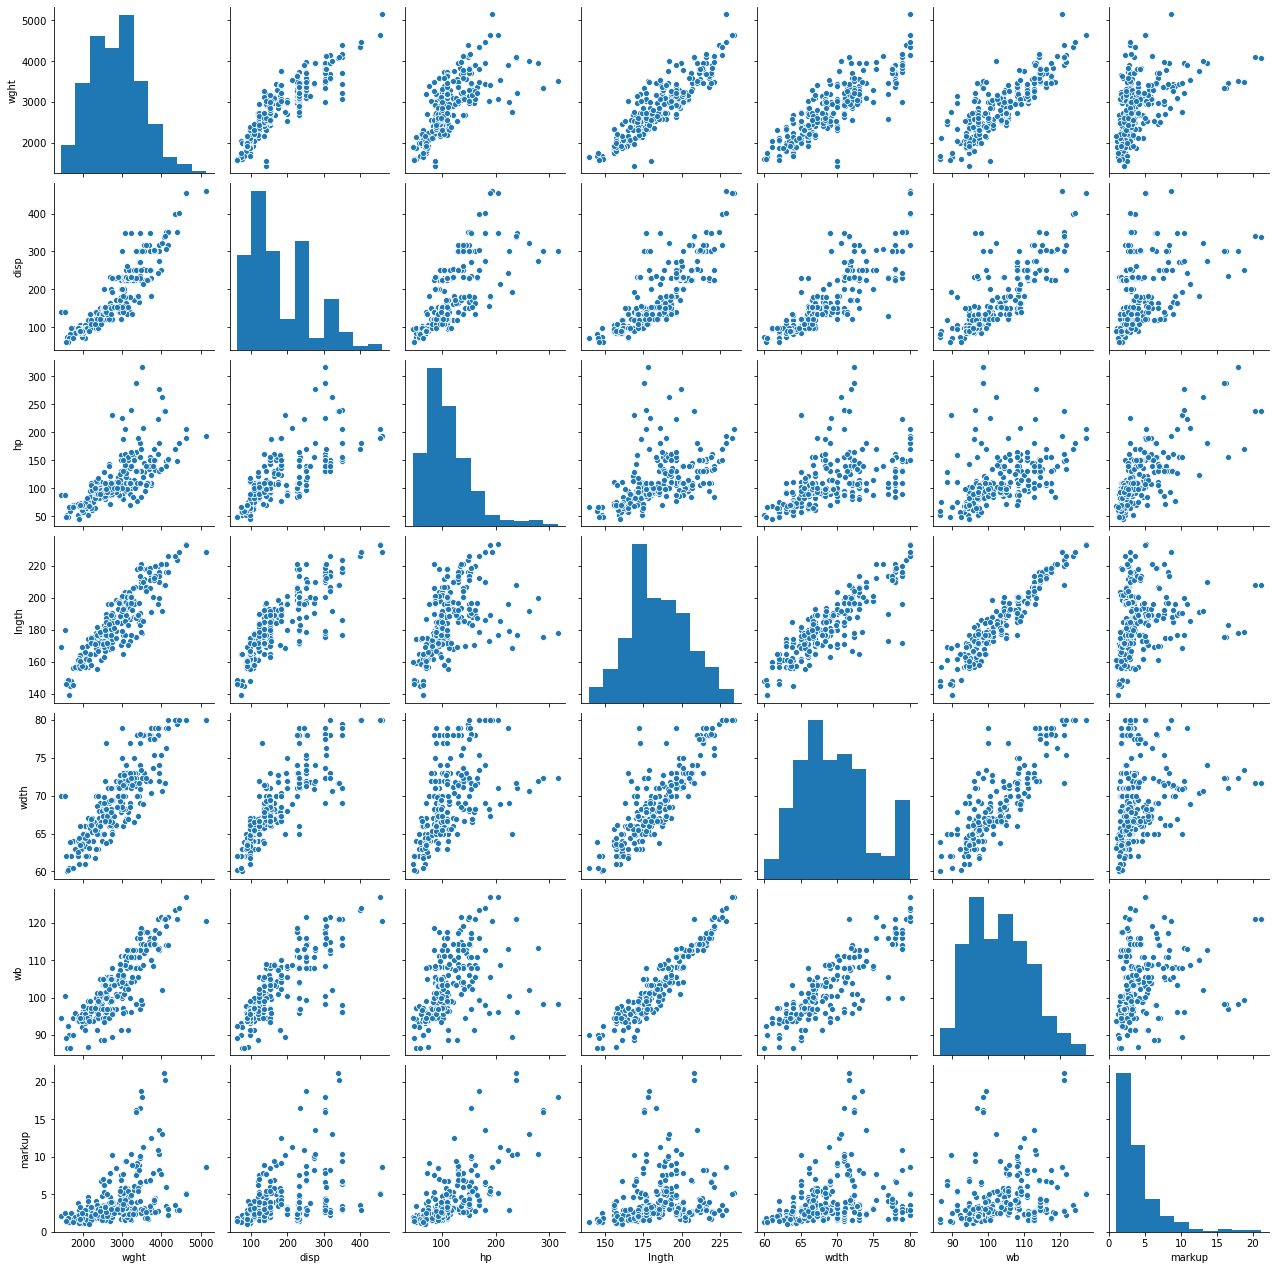

In [3]:
print(test.dtypes)
sns_plot=sns.pairplot(test[['wght', 'disp', 'hp', 'lngth', 'wdth','wb', 'markup']])
sns_plot.savefig("pairplot_test.png")

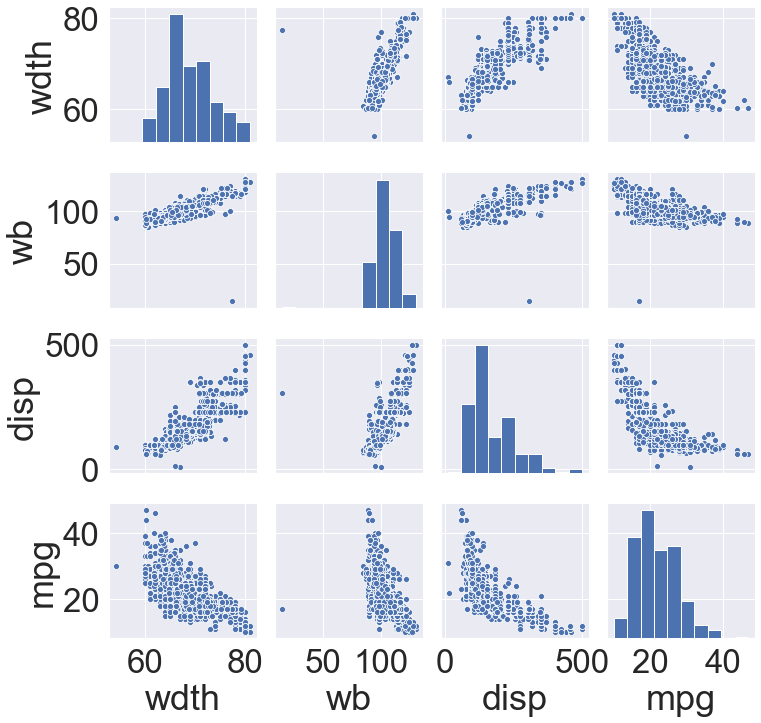

In [4]:
sns.set(font_scale=3)
sns_plot=sns.pairplot(training[['wdth', 'wb', 'disp', 'mpg']])
sns_plot.savefig("pairplot_outliers.png")

In [5]:
def mape(y, y_hat):
    if isinstance(y, pd.DataFrame):
        y=y.to_numpy()
    abs_err = [abs(yi-y_hati)/yi for yi, y_hati in zip(y,y_hat)]
    return sum(abs_err)/len(abs_err)

In [6]:
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold

def forward_selected(x, y, force=[], threshold=0, max_p=.01, random_state=None):
    
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    
    
    
    remaining = list(x.columns)
    selected = []
    
    #forces these variables in the model
    for f in force:
        remaining.remove(f)
        selected.append(f)
        
    current_score, best_new_score = 0.0, 0.0
    
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            bad_pvalue=False
            new_x = x[selected + [candidate]].astype(float)
            errors=[]
            test_train_vars = []
            for train_index, test_index in kf.split(x):
                X_train, X_test = new_x.iloc[train_index], new_x.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                test_train_vars.append((X_train, X_test, y_train, y_test))
                
            for X_train, X_test, y_train, y_test in test_train_vars:
                
                mod_wls = sm.WLS(y_train, X_train, weights=1/y_train).fit()
                if max(mod_wls.pvalues) < max_p:
                    score = 1 - mape(y_test.to_numpy(),mod_wls.predict(X_test.to_numpy()))
                    errors.append(score)
                else:
                    bad_pvalue=True
                    break

            if not bad_pvalue:
                scores_with_candidates.append((sum(errors)/len(errors), candidate))
        
        scores_with_candidates.sort()
        
        #breaks if there are no suitable variables to add
        if len(scores_with_candidates) == 0:
            break
        
        #selects the best variable to be added to the model with min minimum MAPE
        best_new_score, best_candidate = scores_with_candidates.pop()
        if threshold <= best_new_score - current_score:
            print(1 - best_new_score, best_candidate)
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
        else:
            break
    return selected

#best with standard test train split
# m = forward_selected(x, y, threshold = .00000001, max_p=.1, force=[], validation='kfold', random_state=5)#'wght[inv]', 'price[inv]*maker[is_Fiat]', 'maker[is_Porsche]*a/c[is_X]', 'price[inv]', 
# print(m)

# REMOVING OUTLIERS

In [7]:
#removing some outliers:
training = training[training['wdth']>55]
training = training[training['wb']  >40]
training = training[training['disp']>40]
training = training.drop(index=[1442,1166, 1281, 1391, 1392, 1498, 1499,159])
training

# sns_plot=sns.pairplot(training[['wdth', 'wb', 'disp', 'mpg']])
# sns_plot.savefig("pairplot_outliers_after.png")

,origin,maker,model,yr,cyl,2wh,auto,p/s,a/c,fro,...,wdth,wb,reli,fid,dom,eur,sales,price,markup,mpg
id,,,,,,,,,,,,,,,,,,,,,
9,Europe,Volvo,VV-244,75,4,4,0,0,X,0,...,68.0,104.0,3,6,no,Y,12839,5495,3.4016,16
10,Europe,Volvo,VV-164,75,6,4,0,0,X,0,...,68.0,107.0,4,6,no,Y,15997,7495,5.0416,15
11,Europe,Volkswagen,AD-FOX,75,4,4,0,0,X,0,...,65.0,97.2,4,7,no,Y,30305,4850,3.1202,21
12,Europe,Volkswagen,VW-DASH,75,4,4,0,0,X,1,...,63.0,97.2,3,7,no,Y,33271,4650,2.9878,23
13,Europe,Volkswagen,VW-BEET,75,4,2,0,0,X,0,...,61.0,94.5,2,7,no,Y,92037,3295,1.9861,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,U.S.,GM,OD-CTLS,90,4,2,1,1,X,1,...,69.5,104.9,3,19,yes,N,133446,11995,3.6452,23
1494,U.S.,GM,PT-FIRE,90,6,2,0,1,X,0,...,72.4,101.0,2,19,yes,N,38580,11985,3.6580,16
1495,U.S.,GM,CD-ELDO,90,8,2,1,1,O,1,...,72.4,108.0,3,19,yes,N,22832,28855,9.2126,16


# TRANSFORMATIONS

In [8]:
def transforms(training,test,poly_order=1,categories=[], boxcox=False, inv=False):
    from sklearn.preprocessing import LabelEncoder
    training_numeric = training.copy(deep=True)
    test_numeric = test.copy(deep=True)

    for col in categories:#,'dom','eur','origin']:
        lb_make = LabelEncoder()
        lb_make.fit(training[col])
        for i,b in enumerate(lb_make.classes_[1:]):
            training_numeric['{}[is_{}]'.format(col,b)] = training_numeric[col].apply(lambda x : 1 if x == b else 0)
            test_numeric['{}[is_{}]'.format(col,b)] = test_numeric[col].apply(lambda x : 1 if x == b else 0)
    # print(training.columns)
    #only use numeric columns for now
    drop_cols = ['model','origin','maker','a/c','dom','eur', 'fid']
    training_numeric = training_numeric.drop(columns=drop_cols)#.copy(deep=True) #[['cyl','auto','p/s','a/c','wght','disp','hp','lngth','wdth','wb','fid','price','markup','mpg']]
    test_numeric = test_numeric.drop(columns=drop_cols)
    #'yr','2wh','fro','reli','sales','dom','eur',
    # for c in ['cyl','wght','disp','hp','lngth','wdth','wb','price','markup']:
    #     training_numeric[c+'[sqr]'] = (training_numeric[c]-training_numeric[c].mean())**2

    # training_numeric['intercept']=1
    if inv:
        for c in ['wght', 'disp', 'hp', 'lngth', 'wdth','wb', 'markup']:
            training_numeric[c] = 1/training_numeric[c]#+'[^-1]'
            test_numeric[c] = 1/test_numeric[c]

    x=training_numeric.drop(columns=['mpg'])
    test_numeric = test_numeric.drop(columns=['mpg'])

#     def minMax(x):
#         return pd.Series(index=['min','max'],data=[x.min(),x.max()])


#     print(x.apply(minMax))

    import pandas as pd
    from sklearn import preprocessing
    if boxcox:
        pt = preprocessing.PowerTransformer(method = 'box-cox')#box-cox
        # x = pd.DataFrame(pt.fit_transform(x), columns=x.columns, index=x.index)#.reset_index(drop=True)
        # test_numeric = pd.DataFrame(pt.transform(test_numeric), columns=test_numeric.columns, index=test_numeric.index)#.reset_index(drop=True)

        x[['wght','disp','hp','lngth','wdth','wb','price','markup']] = pt.fit_transform(x[['wght','disp','hp','lngth','wdth','wb','price','markup']])
        test_numeric[['wght','disp','hp','lngth','wdth','wb','price','markup']] = pt.transform(test_numeric[['wght','disp','hp','lngth','wdth','wb','price','markup']])
        print(pt.lambdas_)
    # x_np = x.values #returns a numpy array
    # min_max_scaler = preprocessing.MinMaxScaler()
    # x_scaled = min_max_scaler.fit_transform(x_np)
    # x = pd.DataFrame(x_scaled, columns=x.columns, index=x.index)

    # transform = FactorAnalysis(n_components=20, random_state=0)
    # xt = transform.fit_transform(x)
    # print(transform.n_iter_)
    # # vals = pca.explained_variance_ratio_[:20]
    # x = pd.DataFrame(xt, columns = ['FA{}'.format(i) for i in range(xt.shape[1])], index=x.index)

    # df = pd.DataFrame({'var':transform.noise_variance_,
    #              'FA':['FA{}'.format(i) for i in range(len(transform.noise_variance_))]})
    # sns.barplot(x='FA',y="var", 
    #            data=df, color="c");
    # plt.show()

    # pca = PCA(n_components=10)
    # xpca = pca.fit_transform(x)
    # # vals = pca.explained_variance_ratio_[:20]
    # x = pd.DataFrame(xpca, columns = ['PC{}'.format(i) for i in range(xpca.shape[1])], index=x.index)#.reset_index(drop=True)
    # # print(xpca)
    # df = pd.DataFrame({'var':pca.explained_variance_ratio_,
    #              'PC':['PC{}'.format(i) for i in range(x.shape[1])]})
    # sns.barplot(x='PC',y="var", 
    #            data=df, color="c");
    # plt.show()

    # sns_plot=sns.pairplot(x.join(y, how='inner'))
    # sns_plot.savefig("pairplot_pca.png")
    print(x.shape)

    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(poly_order)#, interaction_only=True)
    x_np = poly.fit_transform(x)
    print(x_np.shape)
    target_feature_names = [' x '.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(x.columns,p) for p in poly.powers_]]
    x = pd.DataFrame(x_np, columns=target_feature_names, index=x.index)#.reset_index(drop=True)

    x_np = poly.transform(test_numeric)
    print(x_np.shape)
    target_feature_names = [' x '.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(test_numeric.columns,p) for p in poly.powers_]]
    test_numeric = pd.DataFrame(x_np, columns=target_feature_names, index=test_numeric.index)#.reset_index(drop=True)

    y=training_numeric[['mpg']]#.reset_index(drop=True)

    xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.3, random_state=67)
    # xtrain = xtrain.to_numpy()
    # xtest = xtest.to_numpy()
    # ytrain = ytrain.to_numpy()
    # ytest = ytest.to_numpy()
    # print(training_numeric.columns)
    x.head()
    return x,y,xtrain, xtest, ytrain, ytest,test_numeric

# MODEL SELECTION

In [9]:
def model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=[]):
    m = forward_selected(xtrain, ytrain, threshold = .000001, max_p=.1, force=force, random_state=5)
    model_vars = m
    print(model_vars)

    kf = KFold(n_splits=5, shuffle=True, random_state=5)
    train_score = []
    valid_score = []
    for train_index, test_index in kf.split(xtest):
    #                     print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = xtrain[model_vars].iloc[train_index], xtest[model_vars].iloc[test_index]
        y_train, y_test = ytrain.iloc[train_index], ytest.iloc[test_index]

        mod_wls = sm.WLS(y_train, X_train, weights=1/y_train).fit()#, weights=1/y_train
        model_vars = dict(mod_wls.params)
        train_score.append(mape(y_train.to_numpy(),mod_wls.predict(X_train.to_numpy())))
        valid_score.append(mape(y_test.to_numpy(),mod_wls.predict(X_test.to_numpy())))
    print('training score:',   sum(train_score)/len(train_score))
    print('validation score:', sum(valid_score)/len(valid_score))

    mod_wls = sm.WLS(ytrain, xtrain[m], weights=1/ytrain).fit()
    print('test score:',mape(ytest.to_numpy(),mod_wls.predict(xtest[m].to_numpy())))
    
    return m

In [10]:
def prune(x_vars,xtrain, xtest, ytrain, ytest):
    sns.set(font_scale=1)

    train_vals=[]
    test_vals=[]
#     print(xtrain.index)
#     print(ytrain.index)
#     x_vars = x_poly2_maker_box
    for i in range(1,len(x_vars)):
        sub_vars = x_vars[:i]
        mod_wls = sm.WLS(ytrain, xtrain[sub_vars], weights=1/ytrain).fit()
    #     print(mod_wls.summary())
        train_vals.append(mape(ytrain.to_numpy(),mod_wls.predict(xtrain[sub_vars].to_numpy())))
        test_vals.append(mape(ytest.to_numpy(),mod_wls.predict(xtest[sub_vars].to_numpy())))
    plt.plot(range(1,len(x_vars)),train_vals, label="Training MAPE")
    plt.plot(range(1,len(x_vars)),test_vals, label="Testing MAPE")
    plt.xlabel('Number of Variables')
    plt.ylabel('MAPE')
    plt.legend(loc="upper right")

    best_num_vars = np.argmin(test_vals)+1
    min_mape = min(test_vals)[0]

    plt.annotate('Minimum Testing MAPE of \n%.5f at %d variables' % (min_mape,best_num_vars),
                xy=(best_num_vars, min_mape), xycoords='data',
                xytext=(-15, 25), textcoords='offset points',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='right', verticalalignment='bottom')

    plt.savefig("variable_pruning.png")
    plt.show()
    print('Min test MAPE:',min_mape)
    print('Min num vars:',best_num_vars)
    return min_mape

___________
______________

# INV

# MAKER

In [52]:
#Poly 3 WLS maker instead of origin NO ORIG vars
# mod_poly3 = ['yr^1 x wght^1', 'yr^1 x hp^1', 'hp^2 x a/c[is_X]^1', 'cyl^1 x hp^1 x maker[is_Volkswagen]^1', '2wh^1 x disp^1 x reli^1', '2wh^1 x markup^1 x maker[is_Fiat]^1', 'auto^1 x maker[is_GM]^1 x a/c[is_X]^1', 'disp^1 x hp^1 x a/c[is_X]^1', 'hp^1 x maker[is_Porsche]^1 x a/c[is_X]^1', 'fro^1 x hp^1 x price^1', 'yr^1 x p/s^1 x maker[is_Toyota]^1', 'price^2 x maker[is_Yugo]^1', 'hp^2 x maker[is_Mercedes-Benz]^1', 'auto^1 x maker[is_Mercedes-Benz]^1 x a/c[is_X]^1', 'cyl^1 x hp^2', 'auto^1 x reli^1 x maker[is_Chrysler]^1', 'fro^1 x price^1 x maker[is_Mitsubishi]^1', 'disp^1 x price^1 x maker[is_Subaru]^1', 'hp^2 x maker[is_Peugeot]^1', 'disp^2 x maker[is_Peugeot]^1', 'yr^1 x wght^1 x wdth^1', 'wght^1 x hp^1', 'wght^1 x hp^1 x maker[is_Honda]^1', 'yr^1 x hp^1 x maker[is_Volkswagen]^1','hp^1 x maker[is_Renault]^1 x a/c[is_X]^1']
print('poly 3 WLS maker instead of origin no OG VARS')
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=3,categories=['maker','a/c'], inv=True)
x_poly3_maker = model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=[])

poly 3 WLS maker instead of origin no OG VARS
(1488, 39)
(1488, 11480)
(300, 11480)
[0.09614418] yr^1 x wght^1
[0.08741757] yr^1 x hp^1
[0.08441022] hp^2 x a/c[is_X]^1
[0.08216224] cyl^1 x hp^1 x maker[is_Volkswagen]^1
[0.07998525] 2wh^1 x disp^1 x reli^1
[0.07852965] 2wh^1 x markup^1 x maker[is_Fiat]^1
[0.0773971] auto^1 x maker[is_GM]^1 x a/c[is_X]^1
[0.07628568] disp^1 x hp^1 x a/c[is_X]^1
[0.07560293] hp^1 x maker[is_Porsche]^1 x a/c[is_X]^1
[0.07495619] fro^1 x hp^1 x price^1
[0.07441004] yr^1 x p/s^1 x maker[is_Toyota]^1
[0.07388314] price^2 x maker[is_Yugo]^1
[0.07345019] hp^2 x maker[is_Mercedes-Benz]^1
[0.07293128] auto^1 x maker[is_Mercedes-Benz]^1 x a/c[is_X]^1


KeyboardInterrupt: 

In [ ]:
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=3,categories=['maker','a/c'], inv=True)
x_poly3_maker_mape = prune(x_poly3_maker,xtrain, xtest, ytrain, ytest)

______

In [ ]:
#Poly 2 WLS maker instead of origin NO ORIG vars
print('poly 2 WLS maker instead of origin no OG VARS')
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=2 ,categories=['maker','a/c'], inv=True)
x_poly2_maker = model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=[])

In [ ]:
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=2,categories=['maker','a/c'], inv=True)
x_poly2_maker_mape = prune(x_poly2_maker,xtrain, xtest, ytrain, ytest)

_____

In [ ]:
#Poly 1 WLS maker instead of origin
#tune threshold
print('poly 1 WLS maker instead of origin')
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=1,categories=['maker','a/c'], inv=True)
x_poly1_maker = model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=[])

In [ ]:
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=1,categories=['maker','a/c'], inv=True)
x_poly1_maker_mape = prune(x_poly1_maker,xtrain, xtest, ytrain, ytest)

_______________________

# ORIGIN

In [ ]:

#Poly 3 WLS
print('poly 3 WLS origin')
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=3,categories=['origin','a/c'], inv=True)
x_poly3_origin = model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=[])

In [ ]:
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=3,categories=['origin','a/c'], inv=True)
x_poly3_origin_mape = prune(x_poly3_origin,xtrain, xtest, ytrain, ytest)

_____

In [ ]:
#BEST POLY WLS POLY 2
#Poly 2 WLS
#Min test MAPE: [0.08291731]
# Min num vars: 8
print('poly 2 WLS origin')
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=2,categories=['origin','a/c'], inv=True)
x_poly2_origin = model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=[])

In [ ]:
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=2,categories=['origin','a/c'], inv=True)
x_poly2_origin_mape = prune(x_poly2_origin,xtrain, xtest, ytrain, ytest)

_____

In [ ]:
#Poly 1 WLS origin 
print('poly 1 WLS origin')
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=1,categories=['origin','a/c'], inv=True)
x_poly1_origin = model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=[])

In [ ]:
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=1,categories=['origin','a/c'], inv=True)
x_poly1_origin_mape = prune(x_poly1_origin,xtrain, xtest, ytrain, ytest)

_____

__________

# NEITHER

In [ ]:

#Poly 4 WLS neither
# print('poly 4 WLS neither')
# x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=4,categories=['a/c'], inv=True)
# x_poly4_neither = model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=[])

In [ ]:
# x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=4,categories=['a/c'], inv=True)
# x_poly4_neither_mape = prune(x_poly4_neither,xtrain, xtest, ytrain, ytest)

_____

In [ ]:

#Poly 3 WLS neither
print('poly 3 WLS neither')
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=3,categories=['a/c'], inv=True)
x_poly3_neither = model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=[])

In [ ]:
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=3,categories=['a/c'], inv=True)
x_poly3_neither_mape = prune(x_poly3_neither,xtrain, xtest, ytrain, ytest)

_____

In [ ]:
#BEST POLY WLS POLY 2
#Poly 2 WLS
#Min test MAPE: [0.08291731]
# Min num vars: 8
print('poly 2 WLS neither')
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=2,categories=['a/c'], inv=True)
x_poly2_neither = model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=[])

In [ ]:
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=2,categories=['a/c'], inv=True)
x_poly2_neither_mape = prune(x_poly2_neither,xtrain, xtest, ytrain, ytest)

_____

In [ ]:
#Poly 1 WLS neither 
print('poly 1 WLS neither')
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=1,categories=['a/c'], inv=True)
x_poly1_neither = model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=[])

In [ ]:
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=1,categories=['a/c'], inv=True)
x_poly1_neither_mape = prune(x_poly1_neither,xtrain, xtest, ytrain, ytest)

___________
______

# BOX COX

# MAKER

In [75]:
#Poly 3 WLS maker instead of origin NO ORIG vars
force = ['yr^2', 'yr^2 x hp^1', 'yr^2 x wght^1', 'yr^3', 'wght^1 x reli^1 x markup^1', 'wb^1 x price^1 x maker[is_Fiat]^1', 'disp^1', 'cyl^2 x maker[is_Volkswagen]^1', 'hp^1 x reli^1 x maker[is_Mercedes-Benz]^1', '', 'cyl^1 x price^1 x a/c[is_X]^1', 'hp^1 x reli^1 x markup^1', 'disp^1 x hp^1 x reli^1', 'hp^1 x wdth^1 x price^1', 'wght^1 x markup^1 x maker[is_Peugeot]^1', 'yr^2 x maker[is_Peugeot]^1', 'auto^1 x maker[is_GM]^1 x a/c[is_X]^1', 'reli^1 x sales^1 x maker[is_Mercedes-Benz]^1', 'hp^1 x maker[is_GM]^1 x a/c[is_X]^1', 'wght^1 x wb^1 x maker[is_BMW]^1', 'hp^2 x maker[is_Mazda]^1', 'hp^1 x wdth^1 x maker[is_Alfa Romeo]^1', 'disp^1 x reli^1 x maker[is_Fiat]^1', 'wght^1 x disp^1 x maker[is_Porsche]^1', 'yr^1 x disp^1 x maker[is_Yugo]^1', 'cyl^1 x wght^1 x maker[is_Porsche]^1', 'wght^2 x maker[is_Toyota]^1', 'p/s^1 x fro^1 x maker[is_Toyota]^1']
print('poly 3 WLS maker instead of origin no OG VARS')
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=3,categories=['maker','a/c'], boxcox=True)
x_poly3_maker_box = model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=force)

poly 3 WLS maker instead of origin no OG VARS
(1488, 39)
(1488, 11480)
(300, 11480)
[0.06538687] fro^1 x wb^1 x maker[is_Chrysler]^1
[0.06533158] markup^1 x maker[is_Datsun]^1 x a/c[is_X]^1
['yr^2', 'yr^2 x hp^1', 'yr^2 x wght^1', 'yr^3', 'wght^1 x reli^1 x markup^1', 'wb^1 x price^1 x maker[is_Fiat]^1', 'disp^1', 'cyl^2 x maker[is_Volkswagen]^1', 'hp^1 x reli^1 x maker[is_Mercedes-Benz]^1', '', 'cyl^1 x price^1 x a/c[is_X]^1', 'hp^1 x reli^1 x markup^1', 'disp^1 x hp^1 x reli^1', 'hp^1 x wdth^1 x price^1', 'wght^1 x markup^1 x maker[is_Peugeot]^1', 'yr^2 x maker[is_Peugeot]^1', 'auto^1 x maker[is_GM]^1 x a/c[is_X]^1', 'reli^1 x sales^1 x maker[is_Mercedes-Benz]^1', 'hp^1 x maker[is_GM]^1 x a/c[is_X]^1', 'wght^1 x wb^1 x maker[is_BMW]^1', 'hp^2 x maker[is_Mazda]^1', 'hp^1 x wdth^1 x maker[is_Alfa Romeo]^1', 'disp^1 x reli^1 x maker[is_Fiat]^1', 'wght^1 x disp^1 x maker[is_Porsche]^1', 'yr^1 x disp^1 x maker[is_Yugo]^1', 'cyl^1 x wght^1 x maker[is_Porsche]^1', 'wght^2 x maker[is_Toyota]

[-0.09466148 -0.43856908 -0.20070702 -0.27736606 -2.31571202 -1.64987019
 -0.33435441 -0.44343978]
(1488, 39)
(1488, 11480)
(300, 11480)


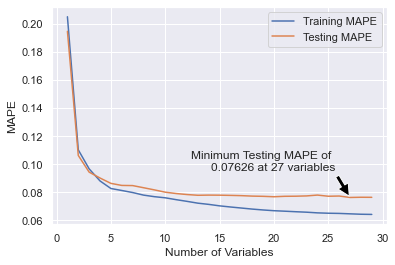

Min test MAPE: 0.07625744187614554
Min num vars: 27


In [84]:
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=3,categories=['maker','a/c'], boxcox=True)
x_poly3_maker_box_mape = prune(x_poly3_maker_box,xtrain, xtest, ytrain, ytest)

______

In [12]:
#Poly 2 WLS maker instead of origin NO ORIG vars
force = ['yr^2', 'yr^1 x hp^1', 'yr^1 x wght^1', '', 'wght^1 x markup^1', 'reli^2', 'cyl^1 x maker[is_Volkswagen]^1', 'price^1 x maker[is_Fiat]^1', 'hp^1 x markup^1', 'hp^1 x maker[is_Peugeot]^1', 'yr^1', 'wght^1 x hp^1', 'cyl^1', 'price^1 x a/c[is_X]^1', 'auto^1 x maker[is_Chrysler]^1', 'price^1 x maker[is_Renault]^1', 'wb^1 x maker[is_Honda]^1', 'disp^1 x reli^1', 'cyl^1 x wdth^1', '2wh^1 x maker[is_Volkswagen]^1', 'hp^1 x maker[is_Mercedes-Benz]^1', 'price^1 x maker[is_Mercedes-Benz]^1', 'yr^1 x maker[is_Yugo]^1', 'fro^1 x disp^1', 'reli^1 x maker[is_Subaru]^1']
print('poly 2 WLS maker instead of origin no OG VARS')
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=2 ,categories=['maker','a/c'], boxcox=True)
x_poly2_maker_box = model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=force)

poly 2 WLS maker instead of origin no OG VARS
[-0.09466148 -0.43856908 -0.20070702 -0.27736606 -2.31571202 -1.64987019
 -0.33435441 -0.44343978]
(1488, 39)
(1488, 820)
(300, 820)
[0.06915373] yr^1 x maker[is_Jaguar]^1
['yr^2', 'yr^1 x hp^1', 'yr^1 x wght^1', '', 'wght^1 x markup^1', 'reli^2', 'cyl^1 x maker[is_Volkswagen]^1', 'price^1 x maker[is_Fiat]^1', 'hp^1 x markup^1', 'hp^1 x maker[is_Peugeot]^1', 'yr^1', 'wght^1 x hp^1', 'cyl^1', 'price^1 x a/c[is_X]^1', 'auto^1 x maker[is_Chrysler]^1', 'price^1 x maker[is_Renault]^1', 'wb^1 x maker[is_Honda]^1', 'disp^1 x reli^1', 'cyl^1 x wdth^1', '2wh^1 x maker[is_Volkswagen]^1', 'hp^1 x maker[is_Mercedes-Benz]^1', 'price^1 x maker[is_Mercedes-Benz]^1', 'yr^1 x maker[is_Yugo]^1', 'fro^1 x disp^1', 'reli^1 x maker[is_Subaru]^1', 'yr^1 x maker[is_Jaguar]^1']
training score: [0.06681911]
validation score: [0.07853527]
test score: [0.07370504]


[-0.09466148 -0.43856908 -0.20070702 -0.27736606 -2.31571202 -1.64987019
 -0.33435441 -0.44343978]
(1488, 39)
(1488, 820)
(300, 820)


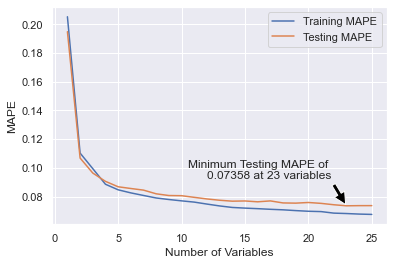

Min test MAPE: 0.07358258974444921
Min num vars: 23


In [13]:
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=2,categories=['maker','a/c'], boxcox=True)
x_poly2_maker_box_mape = prune(x_poly2_maker_box,xtrain, xtest, ytrain, ytest)

<AxesSubplot:>

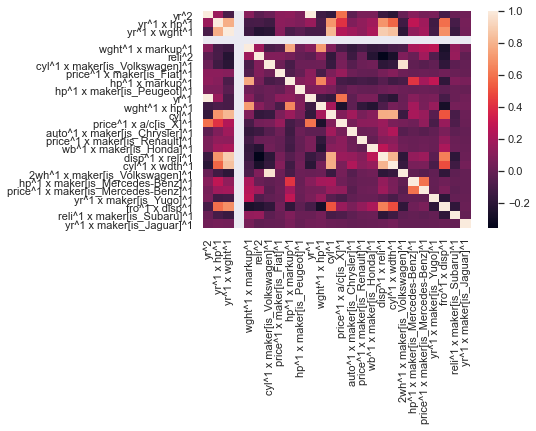

In [21]:
# mod_wls = sm.WLS(ytrain, xtrain[x_poly2_maker_box], weights=1/ytrain).fit()
# mod_wls.summary()
sns.heatmap(np.corrcoef(x[x_poly2_maker_box].transpose()), xticklabels=x_poly2_maker_box, yticklabels=x_poly2_maker_box)

In [102]:
#exporting test values
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=2,categories=['maker','a/c'], boxcox=True)
mod_wls = sm.WLS(ytrain, xtrain[x_poly2_maker_box], weights=1/ytrain).fit()
print('{:e}'.format(mod_wls.params.iloc[-1]))
test_vals = mod_wls.predict(test_numeric[x_poly2_maker_box])
print(test_vals.max())
test_vals.to_csv('test_pred_box.csv')

[-0.09466148 -0.43856908 -0.20070702 -0.27736606 -2.31571202 -1.64987019
 -0.33435441 -0.44343978]
(1488, 39)
(1488, 820)
(300, 820)
0.000000e+00
41.01228877955765


_____

In [80]:
#Poly 1 WLS maker instead of origin
#tune threshold
print('poly 1 WLS maker instead of origin')
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=1,categories=['maker','a/c'], boxcox=True)
x_poly1_maker_box = model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=[])

poly 1 WLS maker instead of origin
[-0.09466148 -0.43856908 -0.20070702 -0.27736606 -2.31571202 -1.64987019
 -0.33435441 -0.44343978]
(1488, 39)
(1488, 40)
(300, 40)
[0.20558685] yr^1
[0.10272244] wght^1
[0.08942703] hp^1
[0.08725842] reli^1
[0.08545649] maker[is_Volkswagen]^1
[0.08437973] maker[is_Fiat]^1
[0.0838041] disp^1
[0.08354165] maker[is_Porsche]^1
['yr^1', 'wght^1', 'hp^1', 'reli^1', 'maker[is_Volkswagen]^1', 'maker[is_Fiat]^1', 'disp^1', 'maker[is_Porsche]^1']
training score: [0.07930828]
validation score: [0.08500918]
test score: [0.08542951]


[-0.09466148 -0.43856908 -0.20070702 -0.27736606 -2.31571202 -1.64987019
 -0.33435441 -0.44343978]
(1488, 39)
(1488, 40)
(300, 40)


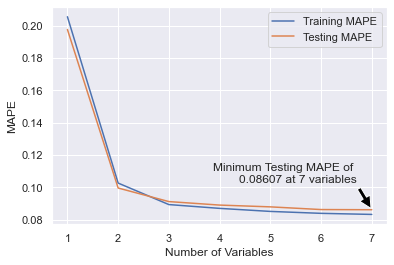

Min test MAPE: 0.086071567464434
Min num vars: 7


In [81]:
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=1,categories=['maker','a/c'], boxcox=True)
x_poly1_maker_box_mape = prune(x_poly1_maker_box,xtrain, xtest, ytrain, ytest)

_______________________

# ORIGIN

In [59]:

#Poly 3 WLS
print('poly 3 WLS origin')
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=3,categories=['origin','a/c'], boxcox=True)
x_poly3_origin_box = model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=[])

poly 3 WLS origin
(1488, 19)
(1488, 1540)
(300, 1540)
[0.20528947] yr^2
[0.11039727] yr^2 x hp^1
[0.09679057] yr^2 x wght^1
[0.08831486] yr^3
[0.08293627] wght^1 x reli^1 x markup^1
[0.08164769] disp^1
[0.0807312] 2wh^1 x hp^1 x markup^1
[0.07935445] 
[0.07779876] cyl^1 x price^1 x a/c[is_X]^1
[0.07645229] 2wh^1 x hp^2
[0.07585822] lngth^2 x markup^1
[0.07549207] origin[is_U.S.]^3
[0.07474654] 2wh^1 x reli^1 x origin[is_Japan]^1
[0.07438122] cyl^1 x p/s^1 x fro^1
[0.07387186] 2wh^1 x p/s^1 x markup^1
[0.07368233] yr^1 x hp^1 x markup^1
[0.07332896] wdth^1 x price^2
[0.07291459] hp^1 x wb^1 x origin[is_U.S.]^1
[0.07261446] p/s^1 x fro^1 x origin[is_U.S.]^1
[0.07228189] yr^1 x sales^1 x origin[is_Japan]^1
[0.07211044] cyl^1 x auto^1 x wght^1
[0.07170085] yr^1 x auto^1 x disp^1
[0.07140436] p/s^1 x fro^1 x markup^1
[0.07125121] hp^2
[0.07113609] disp^2 x origin[is_U.S.]^1
[0.07079096] cyl^3
['yr^2', 'yr^2 x hp^1', 'yr^2 x wght^1', 'yr^3', 'wght^1 x reli^1 x markup^1', 'disp^1', '2wh^1 x h

(1488, 19)
(1488, 1540)
(300, 1540)


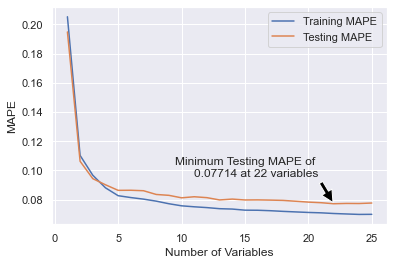

Min test MAPE: 0.07713777842960702
Min num vars: 22


In [60]:
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=3,categories=['origin','a/c'], boxcox=True)
x_poly3_origin_box_mape = prune(x_poly3_origin_box,xtrain, xtest, ytrain, ytest)

_____

In [61]:
#BEST POLY WLS POLY 2
#Poly 2 WLS
#Min test MAPE: [0.08291731]
# Min num vars: 8
print('poly 2 WLS origin')
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=2,categories=['origin','a/c'], boxcox=True)
x_poly2_origin_box = model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=[])

poly 2 WLS origin
(1488, 19)
(1488, 210)
(300, 210)
[0.20528947] yr^2
[0.11053053] yr^1 x hp^1
[0.09962403] yr^1 x wght^1
[0.08885765] 
[0.08503625] wght^1 x markup^1
[0.08296665] reli^2
[0.08206703] yr^1
[0.08064904] yr^1 x cyl^1
[0.0790303] disp^1 x hp^1
[0.07809841] price^1 x a/c[is_X]^1
[0.07635292] hp^1 x markup^1
[0.07605487] disp^1 x origin[is_U.S.]^1
[0.0754734] hp^1 x wb^1
[0.07493047] wght^1 x origin[is_Japan]^1
[0.07431094] cyl^1 x origin[is_U.S.]^1
[0.07398732] p/s^1 x origin[is_U.S.]^1
['yr^2', 'yr^1 x hp^1', 'yr^1 x wght^1', '', 'wght^1 x markup^1', 'reli^2', 'yr^1', 'yr^1 x cyl^1', 'disp^1 x hp^1', 'price^1 x a/c[is_X]^1', 'hp^1 x markup^1', 'disp^1 x origin[is_U.S.]^1', 'hp^1 x wb^1', 'wght^1 x origin[is_Japan]^1', 'cyl^1 x origin[is_U.S.]^1', 'p/s^1 x origin[is_U.S.]^1']
training score: [0.07242316]
validation score: [0.07937978]
test score: [0.07985933]


(1488, 19)
(1488, 210)
(300, 210)


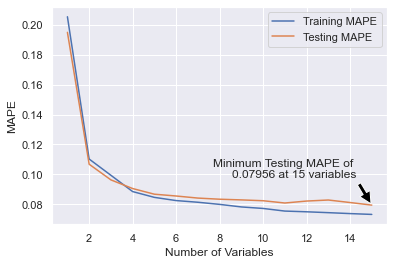

Min test MAPE: 0.07956259866738731
Min num vars: 15


In [62]:
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=2,categories=['origin','a/c'], boxcox=True)
x_poly2_origin_box_mape = prune(x_poly2_origin_box,xtrain, xtest, ytrain, ytest)

_____

In [63]:
#Poly 1 WLS origin 
print('poly 1 WLS origin')
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=1,categories=['origin','a/c'], boxcox=True)
x_poly1_origin_box = model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=[])

poly 1 WLS origin
(1488, 19)
(1488, 20)
(300, 20)
[0.20558685] yr^1
[0.10272244] wght^1
[0.08942703] hp^1
[0.08725842] reli^1
[0.08660654] disp^1
[0.08561479] origin[is_U.S.]^1
[0.08446196] origin[is_Japan]^1
[0.08435765] markup^1
['yr^1', 'wght^1', 'hp^1', 'reli^1', 'disp^1', 'origin[is_U.S.]^1', 'origin[is_Japan]^1', 'markup^1']
training score: [0.08154991]
validation score: [0.08518089]
test score: [0.08584268]


(1488, 19)
(1488, 20)
(300, 20)


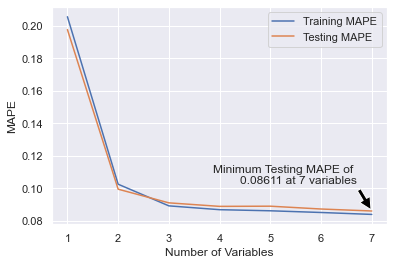

Min test MAPE: 0.08611369170911214
Min num vars: 7


In [64]:
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=1,categories=['origin','a/c'], boxcox=True)
x_poly1_origin_box_mape = prune(x_poly1_origin_box,xtrain, xtest, ytrain, ytest)

_____

__________

# NEITHER

In [65]:

#Poly 4 WLS neither
# print('poly 4 WLS neither')
# x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=4,categories=['a/c'], boxcox=True)
# x_poly4_neither_box = model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=[])

In [66]:
# x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=4,categories=['a/c'], boxcox=True)
# x_poly4_neither_box_mape = prune(x_poly4_neither_box,xtrain, xtest, ytrain, ytest)

_____

In [67]:

#Poly 3 WLS neither
print('poly 3 WLS neither')
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=3,categories=['a/c'], boxcox=True)
x_poly3_neither_box = model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=[])

poly 3 WLS neither
(1488, 17)
(1488, 1140)
(300, 1140)
[0.20528947] yr^2
[0.11039727] yr^2 x hp^1
[0.09679057] yr^2 x wght^1
[0.08831486] yr^3
[0.08293627] wght^1 x reli^1 x markup^1
[0.08164769] disp^1
[0.0807312] 2wh^1 x hp^1 x markup^1
[0.07935445] 
[0.07779876] cyl^1 x price^1 x a/c[is_X]^1
[0.07645229] 2wh^1 x hp^2
[0.07585822] lngth^2 x markup^1
[0.07549498] yr^1 x reli^1 x sales^1
[0.07525025] cyl^1
[0.07491423] 2wh^1 x hp^1 x reli^1
[0.07469758] hp^1 x reli^1 x sales^1
[0.07449911] disp^1 x reli^1 x sales^1
[0.07421927] disp^1 x lngth^1 x markup^1
['yr^2', 'yr^2 x hp^1', 'yr^2 x wght^1', 'yr^3', 'wght^1 x reli^1 x markup^1', 'disp^1', '2wh^1 x hp^1 x markup^1', '', 'cyl^1 x price^1 x a/c[is_X]^1', '2wh^1 x hp^2', 'lngth^2 x markup^1', 'yr^1 x reli^1 x sales^1', 'cyl^1', '2wh^1 x hp^1 x reli^1', 'hp^1 x reli^1 x sales^1', 'disp^1 x reli^1 x sales^1', 'disp^1 x lngth^1 x markup^1']
training score: [0.07318222]
validation score: [0.08018829]
test score: [0.07990406]


(1488, 17)
(1488, 1140)
(300, 1140)


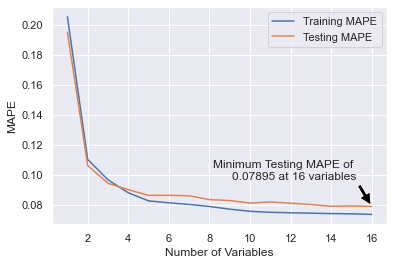

Min test MAPE: 0.07894968220480555
Min num vars: 16


In [68]:
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=3,categories=['a/c'], boxcox=True)
x_poly3_neither_box_mape = prune(x_poly3_neither_box,xtrain, xtest, ytrain, ytest)

_____

In [69]:
#BEST POLY WLS POLY 2
#Poly 2 WLS
#Min test MAPE: [0.08291731]
# Min num vars: 8
print('poly 2 WLS neither')
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=2,categories=['a/c'], boxcox=True)
x_poly2_neither_box = model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=[])

poly 2 WLS neither
(1488, 17)
(1488, 171)
(300, 171)
[0.20528947] yr^2
[0.11053053] yr^1 x hp^1
[0.09962403] yr^1 x wght^1
[0.08885765] 
[0.08503625] wght^1 x markup^1
[0.08296665] reli^2
[0.08206703] yr^1
[0.08064904] yr^1 x cyl^1
[0.0790303] disp^1 x hp^1
[0.07809841] price^1 x a/c[is_X]^1
[0.07635292] hp^1 x markup^1
[0.07623219] yr^1 x reli^1
['yr^2', 'yr^1 x hp^1', 'yr^1 x wght^1', '', 'wght^1 x markup^1', 'reli^2', 'yr^1', 'yr^1 x cyl^1', 'disp^1 x hp^1', 'price^1 x a/c[is_X]^1', 'hp^1 x markup^1', 'yr^1 x reli^1']
training score: [0.07413696]
validation score: [0.08083708]
test score: [0.08080967]


(1488, 17)
(1488, 171)
(300, 171)


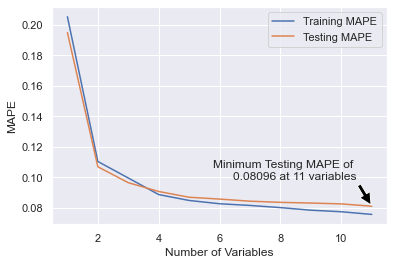

Min test MAPE: 0.08095704284935622
Min num vars: 11


In [70]:
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=2,categories=['a/c'], boxcox=True)
x_poly2_neither_box_mape = prune(x_poly2_neither_box,xtrain, xtest, ytrain, ytest)

_____

In [71]:
#Poly 1 WLS neither 
print('poly 1 WLS neither')
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=1,categories=['a/c'], boxcox=True)
x_poly1_neither_box = model_select(x,y,xtrain, xtest, ytrain, ytest,test_numeric, force=[])

poly 1 WLS neither
(1488, 17)
(1488, 18)
(300, 18)
[0.20558685] yr^1
[0.10272244] wght^1
[0.08942703] hp^1
[0.08725842] reli^1
[0.08660654] disp^1
['yr^1', 'wght^1', 'hp^1', 'reli^1', 'disp^1']
training score: [0.0827716]
validation score: [0.08880447]
test score: [0.08906032]


(1488, 17)
(1488, 18)
(300, 18)


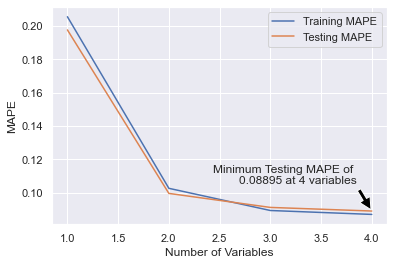

Min test MAPE: 0.08894691493841488
Min num vars: 4


In [72]:
x,y,xtrain, xtest, ytrain, ytest,test_numeric = transforms(training,test,poly_order=1,categories=['a/c'], boxcox=True)
x_poly1_neither_box_mape = prune(x_poly1_neither_box,xtrain, xtest, ytrain, ytest)

_____

In [302]:
#Poly 2 WLS
print('poly 1 WLS FA')
m = forward_selected(xtrain, ytrain, threshold = .0001, max_p=.1, force=[], validation='kfold', random_state=5)
model_vars = m
print(model_vars)

kf = KFold(n_splits=5, shuffle=True, random_state=57)
train_score = []
valid_score = []
for train_index, test_index in kf.split(xtest):
#                     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = xtest[model_vars].iloc[train_index], xtest[model_vars].iloc[test_index]
    y_train, y_test = ytest.iloc[train_index], ytest.iloc[test_index]

    mod_wls = sm.WLS(y_train, X_train, weights=1/y_train).fit()#, weights=1/y_train
    model_vars = dict(mod_wls.params)
    train_score.append(mape(y_train.to_numpy(),mod_wls.predict(X_train.to_numpy())))
    valid_score.append(mape(y_test.to_numpy(),mod_wls.predict(X_test.to_numpy())))
print('training score:',   sum(train_score)/len(train_score))
print('validation score:', sum(valid_score)/len(valid_score))

mod_wls = sm.WLS(ytrain, xtrain[m], weights=1/ytrain).fit()
print('test score:',mape(ytest.to_numpy(),mod_wls.predict(xtest[m].to_numpy())))

poly 2 WLS
[0.21331056] 
[0.12539785] FA1^1
[0.10955022] FA5^1
[0.10104972] FA3^1
[0.09599849] FA7^1
[0.09172855] FA4^1
[0.08848891] FA10^1
[0.08692953] FA8^1
[0.08589046] FA6^1
[0.08512649] FA13^1
[0.08451074] FA17^1
[0.0834005] FA12^1
[0.08264228] FA0^1
[0.08202582] FA11^1
[0.08155098] FA18^1
[0.08118599] FA9^1
['', 'FA1^1', 'FA5^1', 'FA3^1', 'FA7^1', 'FA4^1', 'FA10^1', 'FA8^1', 'FA6^1', 'FA13^1', 'FA17^1', 'FA12^1', 'FA0^1', 'FA11^1', 'FA18^1', 'FA9^1']
training score: [0.079592]
validation score: [0.08182847]
test score: [0.08131416]


In [ ]:
# poly3origin="['yr^1 x wght[^-1]^1', 'yr^1 x hp[^-1]^1', 'hp[^-1]^2 x price[^-1]^1', 'reli^3', 'origin[is_U.S.]^1 x disp[^-1]^1 x price[^-1]^1', 'disp^1 x price^1 x origin[is_Japan]^1', 'cyl^1 x a/c[is_X]^1 x hp[^-1]^1', 'origin[is_U.S.]^1 x hp[^-1]^2', 'markup^1 x origin[is_U.S.]^1 x a/c[is_X]^1', 'cyl^2 x fro^1', 'fro^1 x price^1 x a/c[is_X]^1', 'yr^1 x fro^1 x wdth^1', 'fro^2 x wdth^1', 'markup^1 x a/c[is_X]^1 x wght[^-1]^1', 'hp[^-1]^1 x wb[^-1]^1 x price[^-1]^1', 'fro^2 x wght^1', 'cyl^1 x sales^1 x origin[is_Japan]^1']"
# poly2origin="['yr^1 x wght[^-1]^1', 'yr^1 x hp[^-1]^1', 'p/s^1 x reli^1', 'a/c[is_X]^1 x hp[^-1]^1', '2wh^1 x origin[is_Japan]^1', 'origin[is_U.S.]^1 x disp[^-1]^1', 'fro^1 x price^1', 'markup^1 x hp[^-1]^1', 'reli^1 x disp[^-1]^1', 'markup^1 x disp[^-1]^1', 'cyl^1 x fro^1', 'sales^1 x origin[is_Japan]^1', 'cyl^1 x wght[^-1]^1', 'price^1 x a/c[is_X]^1', 'cyl^1 x markup^1']"
# poly3maker="['yr^1 x wght[^-1]^1', 'yr^1 x hp[^-1]^1', 'hp[^-1]^2 x price[^-1]^1', 'cyl^1 x maker[is_Volkswagen]^1 x hp[^-1]^1', 'reli^3', 'price^1 x maker[is_Fiat]^1 x wb[^-1]^1', 'price^1 x a/c[is_X]^1 x disp[^-1]^1', 'cyl^1 x a/c[is_X]^1 x markup[^-1]^1', 'auto^1 x maker[is_GM]^1 x a/c[is_X]^1', 'wght^1 x hp^1 x maker[is_Peugeot]^1', 'p/s^1 x hp^1 x maker[is_Ford]^1', 'sales^1 x maker[is_Porsche]^1 x a/c[is_X]^1', 'p/s^1 x maker[is_Volvo]^1 x a/c[is_X]^1', 'maker[is_Mercedes-Benz]^1 x hp[^-1]^2', 'p/s^1 x wdth^1 x maker[is_Peugeot]^1', 'p/s^1 x maker[is_Toyota]^1 x lngth[^-1]^1', 'maker[is_Mazda]^1 x hp[^-1]^1 x price[^-1]^1', 'disp^1 x maker[is_Mazda]^1 x markup[^-1]^1', 'a/c[is_X]^1 x price[^-1]^1 x markup[^-1]^1', 'maker[is_Yugo]^1 x hp[^-1]^2', 'price^1 x a/c[is_X]^1 x wght[^-1]^1', 'maker[is_Mercedes-Benz]^1 x wght[^-1]^1 x price[^-1]^1', 'fro^1 x wdth^1 x maker[is_Mitsubishi]^1', 'fro^1 x wb^1 x maker[is_Subaru]^1', 'lngth^1 x maker[is_Renault]^1 x price[^-1]^1', 'wb^1 x sales^1 x disp[^-1]^1', 'wght[^-1]^2 x disp[^-1]^1', 'a/c[is_X]^1 x wght[^-1]^1 x hp[^-1]^1', 'hp^1 x wb^1 x maker[is_Ford]^1', 'wdth^1 x wght[^-1]^2', 'maker[is_GM]^1 x disp[^-1]^1 x price[^-1]^1', 'maker[is_GM]^1 x markup[^-1]^2', 'maker[is_Volkswagen]^1 x hp[^-1]^1 x lngth[^-1]^1', 'wdth^1 x hp[^-1]^2', 'cyl^2 x fro^1', 'auto^1 x sales^1 x price[^-1]^1', 'disp^1 x maker[is_Volkswagen]^1 x disp[^-1]^1', '2wh^2 x maker[is_Volkswagen]^1', 'yr^1 x disp[^-1]^1 x hp[^-1]^1', 'markup^1 x a/c[is_X]^1 x wb[^-1]^1', 'disp[^-1]^1 x hp[^-1]^1', 'price^1 x maker[is_Ford]^1 x markup[^-1]^1', 'price^1 x price[^-1]^2']"
# poly2maker="['yr^1 x wght[^-1]^1', 'yr^1 x hp[^-1]^1', 'maker[is_Volkswagen]^1 x hp[^-1]^1', 'price^1 x maker[is_Fiat]^1', 'hp[^-1]^1 x markup[^-1]^1', 'wght[^-1]^1 x markup[^-1]^1', 'reli^2', 'reli^1 x a/c[is_X]^1', 'wght^1 x maker[is_Peugeot]^1', 'markup^1 x maker[is_Peugeot]^1', 'auto^1 x maker[is_GM]^1', '2wh^1 x disp[^-1]^1', 'cyl^1 x fro^1', 'maker[is_Porsche]^1 x a/c[is_X]^1', 'fro^1 x maker[is_Toyota]^1', 'maker[is_Mazda]^1 x price[^-1]^1', 'disp^1 x maker[is_Chrysler]^1', 'wdth^1 x markup[^-1]^1', 'disp[^-1]^1 x markup[^-1]^1', 'maker[is_Mazda]^1 x disp[^-1]^1', 'wght^1 x maker[is_Volkswagen]^1', 'wdth^2', 'auto^1 x hp^1']"
# arr = []
# for c in training.columns:
#     arr.append([c, poly2maker.count(c), poly3maker.count(c)])
# pd.DataFrame(arr, columns=['var','2o','3o'])

In [599]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
var = x_poly3_maker
mod_wls = sm.WLS(y, x[var], weights=1/y)
res = sm.OLS(mod_wls.wendog, mod_wls.wexog).fit()
mod_wls=mod_wls.fit()
infl = res.get_influence()
# print(mod_wls.get_influence())
# sm.graphics.influence_plot(res, criterion="cooks")
# plt.show()
# print(infl.cooks_distance)
# plt.scatter(y,mod_wls.predict(x[x_poly3_maker].to_numpy()))
plt.scatter(res.resid, infl.cooks_distance[0])
# plt.scatter(res.resid, y)
print(np.argmax(infl.cooks_distance[0]))
# sm.graphics.plot_leverage_resid2(res)
# sm.qqplot(res.resid)`
plt.show()
res.summary()
x['cooks'] = infl.cooks_distance[0]

KeyError: "['yr^2 x maker[is_Jaguar]^1'] not in index"

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Poly 1 WLS best threshold


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:16<00:00, 15.22s/it]


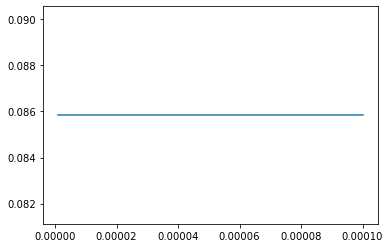

In [258]:
from tqdm import tqdm
#Poly 1 WLS best threshold
print('Poly 1 WLS best threshold')
ivals=np.linspace(.000001, .0001, num=5)
val = []
for i in tqdm(ivals):
    m = forward_selected(xtrain, ytrain, threshold = i, max_p=.1, force=[], validation='kfold', random_state=5)
    mod_wls = sm.WLS(ytrain, xtrain[m], weights=1/ytrain).fit()
    val.append(mape(ytest.to_numpy(),mod_wls.predict(xtest[m].to_numpy())))
plt.plot(ivals,val)
plt.show()

In [590]:
x.sort_values('cooks', ascending=False).head()

,,yr^1,cyl^1,2wh^1,auto^1,p/s^1,fro^1,wght^1,disp^1,hp^1,...,maker[is_Volvo]^2 x maker[is_Yugo]^1,maker[is_Volvo]^2 x a/c[is_X]^1,maker[is_Volvo]^1 x maker[is_Yugo]^2,maker[is_Volvo]^1 x maker[is_Yugo]^1 x a/c[is_X]^1,maker[is_Volvo]^1 x a/c[is_X]^2,maker[is_Yugo]^3,maker[is_Yugo]^2 x a/c[is_X]^1,maker[is_Yugo]^1 x a/c[is_X]^2,a/c[is_X]^3,cooks
id,,,,,,,,,,,,,,,,,,,,,
1393,1.0,89.0,6.0,2.0,1.0,1.0,0.0,0.000256,0.004566,0.005128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.623689e+10
520,1.0,81.0,4.0,5.0,0.0,0.0,1.0,0.000485,0.010941,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.753331e-02
1211,1.0,88.0,4.0,4.0,0.0,1.0,1.0,0.000325,0.008203,0.009804,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.003158e-02
316,1.0,79.0,4.0,2.0,0.0,0.0,1.0,0.000621,0.013245,0.019231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.881834e-02
152,1.0,77.0,4.0,2.0,0.0,0.0,1.0,0.000621,0.013245,0.019231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.513756e-02


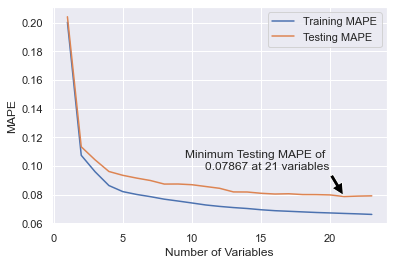

Min test MAPE: 0.07866581420847966
Min num vars: 21
id
1501    27.017971
1502    14.105243
1503    18.536658
1504    16.468888
1505    16.709479
          ...    
1796    15.370507
1797    23.281857
1798    18.074730
1799    14.902271
1800    11.134493
Length: 300, dtype: float64


In [609]:
#removing vars for maker poly3
sns.set(font_scale=1)

# x_poly2_maker_trans = ['yr^2', 'yr^1 x hp^1', 'yr^1 x wght^1', '', 'wght^1 x markup^1', 'reli^2', 'cyl^1 x maker[is_Volkswagen]^1', 'price^1 x maker[is_Fiat]^1', 'hp^1 x markup^1', 'yr^1', 'hp^2', 'cyl^1', 'price^1 x a/c[is_X]^1', 'hp^1 x maker[is_Peugeot]^1', 'wght^1 x disp^1', 'cyl^1 x maker[is_Mitsubishi]^1', 'wb^1 x maker[is_Honda]^1', 'price^1 x maker[is_Renault]^1', '2wh^1 x maker[is_Volkswagen]^1', 'fro^1 x maker[is_Toyota]^1', 'disp^1 x maker[is_Yugo]^1', 'price^1 x maker[is_Chrysler]^1', 'p/s^1 x markup^1', 'fro^1 x maker[is_Volkswagen]^1']
# x_poly2_maker_box = ['yr^2', 'yr^1 x hp^1', 'yr^1 x wght^1', '', 'wght^1 x markup^1', 'reli^2', 'cyl^1 x maker[is_Volkswagen]^1', 'price^1 x maker[is_Fiat]^1', 'hp^1 x markup^1', 'yr^1', 'hp^2', 'cyl^1', 'price^1 x a/c[is_X]^1', 'hp^1 x maker[is_Peugeot]^1', 'wght^1 x disp^1', 'maker[is_Mitsubishi]^2', 'wb^1 x maker[is_Honda]^1', 'price^1 x maker[is_Renault]^1', '2wh^1 x maker[is_Volkswagen]^1', 'fro^1 x maker[is_Toyota]^1', 'disp^1 x maker[is_Yugo]^1', 'price^1 x maker[is_Chrysler]^1', 'p/s^1 x markup^1', 'fro^1 x maker[is_Volkswagen]^1']
# x_poly4_maker = ['yr^1 x wght^1', 'yr^1 x hp^1', 'cyl^1 x hp^2 x wb^1', 'cyl^2 x disp^1 x reli^1', 'cyl^3 x maker[is_Volkswagen]^1', '2wh^2 x markup^1 x maker[is_Fiat]^1', 'auto^1 x hp^1 x reli^1 x maker[is_Chrysler]^1', 'reli^1 x markup^1 x maker[is_Porsche]^1 x a/c[is_X]^1', 'p/s^1 x markup^1 x maker[is_Ford]^1 x a/c[is_X]^1', 'disp^4', 'hp^2 x markup^1 x a/c[is_X]^1', 'auto^1 x reli^1 x maker[is_Mercedes-Benz]^1 x a/c[is_X]^1', '2wh^2 x price^1 x maker[is_Volkswagen]^1', 'p/s^1 x fro^1 x hp^1 x price^1', 'auto^1 x p/s^1 x wb^2', 'yr^3 x wdth^1', 'hp^3 x maker[is_Mazda]^1', 'wght^1 x disp^1 x markup^1 x maker[is_Mazda]^1', 'hp^2 x price^1 x maker[is_Toyota]^1', 'hp^3 x maker[is_Mercedes-Benz]^1', 'disp^2 x reli^1 x maker[is_Chrysler]^1', 'disp^1 x wdth^1 x reli^1 x maker[is_Chrysler]^1', 'sales^1 x markup^3', 'cyl^1 x hp^1 x reli^1 x maker[is_Toyota]^1', 'wdth^2 x reli^1 x a/c[is_X]^1', 'sales^1 x markup^1 x maker[is_Volvo]^1 x a/c[is_X]^1', 'cyl^1 x hp^1 x price^1 x markup^1', '2wh^1 x disp^1 x sales^1 x maker[is_Ford]^1']
# x_poly3_maker = ['yr^1 x wght^1', 'yr^1 x hp^1', 'hp^2 x a/c[is_X]^1', 'cyl^1 x hp^1 x maker[is_Volkswagen]^1', '2wh^1 x disp^1 x reli^1', '2wh^1 x markup^1 x maker[is_Fiat]^1', 'auto^1 x maker[is_GM]^1 x a/c[is_X]^1', 'disp^1 x hp^1 x a/c[is_X]^1', 'hp^1 x maker[is_Porsche]^1 x a/c[is_X]^1', 'fro^1 x hp^1 x price^1', 'yr^1 x p/s^1 x maker[is_Toyota]^1', 'price^2 x maker[is_Yugo]^1', 'hp^2 x maker[is_Mercedes-Benz]^1', 'auto^1 x maker[is_Mercedes-Benz]^1 x a/c[is_X]^1', 'cyl^1 x hp^2', 'auto^1 x reli^1 x maker[is_Chrysler]^1', 'fro^1 x price^1 x maker[is_Mitsubishi]^1', 'disp^1 x price^1 x maker[is_Subaru]^1', 'hp^2 x maker[is_Peugeot]^1', 'disp^2 x maker[is_Peugeot]^1', 'yr^1 x wght^1 x wdth^1', 'wght^1 x hp^1', 'wght^1 x hp^1 x maker[is_Honda]^1', 'yr^1 x hp^1 x maker[is_Volkswagen]^1', 'hp^1 x maker[is_Renault]^1 x a/c[is_X]^1', 'lngth^1 x markup^1 x maker[is_Honda]^1', 'wght^2 x disp^1', 'yr^2 x maker[is_Jaguar]^1', 'wght^3']
# x_poly2_maker = ['yr^1 x wght^1', 'yr^1 x hp^1', 'hp^1 x maker[is_Volkswagen]^1', '2wh^1 x reli^1', 'markup^1 x maker[is_Fiat]^1', 'hp^1 x markup^1', 'disp^1 x markup^1', 'wght^1 x markup^1', 'price^1 x a/c[is_X]^1', 'p/s^1 x maker[is_Toyota]^1', 'auto^1 x maker[is_Chrysler]^1', 'reli^1 x maker[is_Renault]^1', 'price^1 x maker[is_Yugo]^1', 'auto^1 x p/s^1', 'cyl^1 x fro^1', 'fro^1 x maker[is_Subaru]^1', '2wh^1 x maker[is_Mitsubishi]^1']
# x_poly1_maker = ['wght^1', 'maker[is_Volkswagen]^1', 'maker[is_Fiat]^1', 'maker[is_Porsche]^1', 'disp^1', 'yr^1', 'wdth^1', 'hp^1', 'cyl^1', 'a/c[is_X]^1', 'maker[is_Yugo]^1', 'maker[is_Toyota]^1', 'maker[is_Saab]^1']

# x_poly4_origin = ['yr^1 x wght^1', 'yr^1 x hp^1', 'cyl^1 x hp^2 x wb^1', 'cyl^2 x disp^1 x reli^1', 'disp^3 x origin[is_U.S.]^1', 'price^1 x markup^1 x origin[is_U.S.]^1 x a/c[is_X]^1', 'fro^1 x hp^1 x reli^1 x price^1', '2wh^1 x sales^1 x markup^1 x origin[is_Japan]^1', 'cyl^1 x auto^1 x price^1 x origin[is_U.S.]^1', 'hp^1 x reli^3', 'reli^2 x price^1 x a/c[is_X]^1', 'wght^1 x wdth^2 x reli^1', '2wh^1 x fro^1 x lngth^1 x reli^1']
# x_poly3_origin = ['yr^1 x wght^1', 'yr^1 x hp^1', 'hp^2 x a/c[is_X]^1', 'reli^3', 'disp^2 x origin[is_U.S.]^1', 'sales^1 x markup^1 x origin[is_Japan]^1', 'p/s^1 x fro^1 x price^1', 'cyl^1 x hp^2', 'auto^1 x price^1 x origin[is_U.S.]^1', 'price^1 x markup^1 x origin[is_U.S.]^1', 'yr^1 x hp^1 x wb^1', 'reli^1 x price^1 x a/c[is_X]^1', '2wh^1 x origin[is_Japan]^1 x a/c[is_X]^1', 'price^1 x a/c[is_X]^2', 'auto^1 x hp^1 x markup^1', 'auto^1 x wght^1 x markup^1', 'p/s^1 x hp^1 x wb^1']
# x_poly2_origin = ['yr^1 x wght^1', 'yr^1 x hp^1', 'p/s^1 x reli^1', 'hp^1 x a/c[is_X]^1', '2wh^1 x origin[is_Japan]^1', 'disp^1 x origin[is_U.S.]^1', 'fro^1 x price^1', 'disp^1 x reli^1', 'wght^1 x reli^1', '', 'sales^1 x origin[is_Japan]^1', 'yr^1 x cyl^1']
# x_poly1_origin = ['wght^1', 'hp^1', 'a/c[is_X]^1', 'p/s^1', 'cyl^1', 'origin[is_U.S.]^1', 'origin[is_Japan]^1', '', 'price^1', 'disp^1', 'wdth^1']

# x_poly4_neither = ['yr^1 x wght^1', 'yr^1 x hp^1', 'cyl^1 x hp^2 x lngth^1', 'cyl^1 x reli^3', 'cyl^1 x reli^1 x price^1 x a/c[is_X]^1', 'p/s^1 x fro^1 x hp^1 x reli^1', 'hp^3 x price^1', 'disp^1 x reli^2 x sales^1']
# x_poly3_neither = ['yr^1 x wght^1', 'yr^1 x hp^1', 'hp^2 x a/c[is_X]^1', 'reli^3', 'cyl^1 x hp^2', 'reli^1 x price^1 x a/c[is_X]^1', 'fro^1 x disp^1 x price^1', 'disp^1 x reli^1 x sales^1', 'auto^1 x p/s^1 x wght^1']
# x_poly2_neither = ['yr^1 x wght^1', 'yr^1 x hp^1', 'p/s^1 x reli^1', 'hp^1 x a/c[is_X]^1', 'disp^1 x sales^1', 'sales^2', 'fro^1 x price^1', 'cyl^1 x wght^1', 'yr^1 x cyl^1', 'hp^2', 'yr^1 x p/s^1', 'a/c[is_X]^2', 'p/s^1 x wb^1', 'reli^2', '2wh^1 x hp^1', 'wght^1 x a/c[is_X]^1', 'disp^1 x hp^1']
# x_poly1_neither = ['wght^1', 'hp^1', 'a/c[is_X]^1', 'p/s^1', 'cyl^1', '2wh^1', 'auto^1', '']

train_vals=[]
test_vals=[]

x_vars = x_poly2_maker_box
for i in range(1,len(x_vars)):
    sub_vars = x_vars[:i]
    mod_wls = sm.WLS(ytrain, xtrain[sub_vars], weights=1/ytrain).fit()
#     print(mod_wls.summary())
    train_vals.append(mape(ytrain.to_numpy(),mod_wls.predict(xtrain[sub_vars].to_numpy())))
    test_vals.append(mape(ytest.to_numpy(),mod_wls.predict(xtest[sub_vars].to_numpy())))
plt.plot(range(1,len(x_vars)),train_vals, label="Training MAPE")
plt.plot(range(1,len(x_vars)),test_vals, label="Testing MAPE")
plt.xlabel('Number of Variables')
plt.ylabel('MAPE')
plt.legend(loc="upper right")

best_num_vars = np.argmin(test_vals)+1
min_mape = min(test_vals)[0]

plt.annotate('Minimum Testing MAPE of \n%.5f at %d variables' % (min_mape,best_num_vars),
            xy=(best_num_vars, min_mape), xycoords='data',
            xytext=(-15, 25), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom')

plt.savefig("variable_pruning.png")
plt.show()
print('Min test MAPE:',min_mape)
print('Min num vars:',best_num_vars)

best_vars = x_vars[:best_num_vars]
mod_wls = sm.WLS(ytrain, xtrain[best_vars], weights=1/ytrain).fit()
mod_wls.summary()

test_numeric = test_numeric.sort_index()
y_test_pred = mod_wls.predict(test_numeric[best_vars])

print(y_test_pred)

y_test_pred.to_csv('test_mpg_vals.csv')

# pd.set_option('display.float_format', None)
# print(pd.DataFrame(mod_wls.params).to_latex())

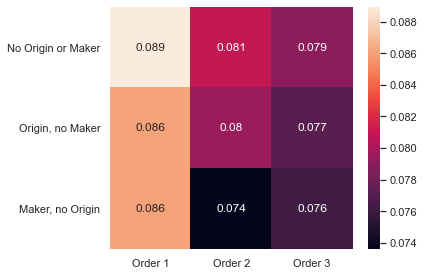

In [83]:
#summary
# test_vals = [[0.09471145657455846,0.08770070191364097,0.08269530642262007],
#              [0.08393006984058743,0.08376278519263675,0.0796200799890602],
#              [0.08409197024032153,0.08139929692644327,0.0767178725071491],
#              [0.0850445112022035,0.08172667253374492,0.07989227073862273]]
test_vals = [[x_poly1_neither_box_mape, x_poly1_origin_box_mape,x_poly1_maker_box_mape],
             [x_poly2_neither_box_mape, x_poly2_origin_box_mape,x_poly2_maker_box_mape],
             [x_poly3_neither_box_mape, x_poly3_origin_box_mape,x_poly3_maker_box_mape]]
#              [x_poly4_neither_box_mape, x_poly4_origin_box_mape,x_poly4_maker_box_mape]]
test_vals = pd.DataFrame(test_vals, columns=['No Origin or Maker','Origin, no Maker','Maker, no Origin'], index = ['Order %d' % i for i in range(1,4)]).transpose()

ax = sns.heatmap(test_vals, annot=True)#, fmt="d")
plt.tight_layout()
plt.savefig("test_rate_heatmap.png")
plt.show()

In [ ]:
sns_plot=sns.pairplot(training_numeric[['wght[inv]','disp[inv]','hp[inv]','lngth[inv]','wdth[inv]','wb','mpg']])
sns_plot.savefig("pairplot_trans.png")

In [53]:
# training_numeric.corr()
training_numeric.head(5)

,cyl,auto,p/s,a/c,wght,disp,hp,lngth,wdth,wb,...,markup[sqr],intercept,wght[inv],disp[inv],hp[inv],lngth[inv],wdth[inv],wb[inv],price[inv],markup[inv]
id,,,,,,,,,,,,,,,,,,,,,
9,4,0,0,1,2905,121.0,98,193.0,68.0,104.0,...,0.848110,1,0.000344,0.008264,0.010204,0.005181,0.014706,0.009615,0.000182,0.293979
10,6,0,0,1,3260,182.0,130,192.0,68.0,107.0,...,0.517063,1,0.000307,0.005495,0.007692,0.005208,0.014706,0.009346,0.000133,0.198350
11,4,0,0,1,2038,97.0,81,173.0,65.0,97.2,...,1.445595,1,0.000491,0.010309,0.012346,0.005780,0.015385,0.010288,0.000206,0.320492
12,4,0,0,1,2050,89.7,71,173.0,63.0,97.2,...,1.781502,1,0.000488,0.011148,0.014085,0.005780,0.015873,0.010288,0.000215,0.334694
13,4,0,0,1,1831,96.7,46,160.0,61.0,94.5,...,5.458901,1,0.000546,0.010341,0.021739,0.006250,0.016393,0.010582,0.000303,0.503499


In [55]:
from sklearn.linear_model import LinearRegression

print(xtrain.shape)

#estimate optimal parameters
reg= LinearRegression().fit(xtrain,ytrain)
print('training rsq:',reg.score(xtrain,ytrain))
print('test rsq:',reg.score(xtest,ytest))
print(mape(reg.predict(xtrain),ytrain))
print(mape(reg.predict(xtest),ytest))

(1047, 24)
training rsq: 0.7862877135097668
test rsq: 0.7718895764444851
[0.08287689]
[0.08886629]


In [157]:
from scipy.optimize import minimize

def objective_function(beta, x, y):
#     beta = beta.reshape(beta.shape[0],1)
#     print(beta.shape, x.shape,y.shape)
#     y_hat = np.matmul(x.to_numpy(),beta)
    return mape(np.matmul(x.to_numpy(),beta), y.to_numpy())

def mape_der(beta, x, y):
#     print(beta)
    der = np.zeros_like(beta)
    y_hat = np.dot(x,beta)
    for j,b in enumerate(beta):
        der[j] = sum([-x[i,j]*(yi - y_hat[i])/(yi*abs(yi - y_hat[i])) for i,yi in enumerate(y)])
    return der

count=1
import sys
def callback(b):
    global count
    sys.stdout.write("\rItterations: %i" % (count))
    sys.stdout.flush()
    count += 1

beta_init = np.ones(len(model_vars.keys()))
print(beta_init)
# def gd(objective, x, y, b0, delta, e):
#     count = 1
#     prev = 0
#     b0 = np.transpose(b0)
#     current = objective(b0, x, y)
#     while abs(prev - current) > e:
#         callback(current)
#         prev = current
#         b0 = b0 - delta * mape_der(b0, x, y)/count
#         current = objective(b0, x, y)
#         count += 1
#     return b0, current
# b_hat, obj = gd(objective_function, xtrain, ytrain, beta_init, .0000001, .1)
# print(obj)
# print(xtrain[model_vars.keys()])
result = minimize(objective_function, beta_init, args=(xtrain[model_vars.keys()],ytrain),
                  method='BFGS', callback=callback, options={'maxiter': 50}) # jac=mape_der
# BFGS SLSQP

[1. 1. 1. 1. 1. 1. 1. 1.]
      wght[inv]   hp[inv]  price[inv]  markup[inv]   wb[inv]   fid[sqr]  fid  \
id                                                                             
490    0.000334  0.010204    0.000102     0.272636  0.009588  55.929602    6   
703    0.000266  0.007692    0.000093     0.279096  0.008749  20.442971   18   
1449   0.000396  0.010870    0.000092     0.378874  0.010288   6.357409   16   
302    0.000315  0.009091    0.000265     0.403682  0.009009  30.485752   19   
126    0.000377  0.014286    0.000291     0.374000  0.010309  30.485752   19   
...         ...       ...         ...          ...       ...        ...  ...   
601    0.000367  0.010870    0.000124     0.348262  0.010040   6.357409   16   
16     0.000303  0.010204    0.000168     0.249401  0.010152  30.015163    8   
1479   0.000233  0.007143    0.000036     0.114605  0.008230  30.485752   19   
299    0.000216  0.005263    0.000106     0.146086  0.008197  30.485752   19   
346    0.00032

In [158]:
beta_hat = result.x
# print(beta_hat)
print(result)

print('training mape: ', objective_function(beta_hat, xtrain[model_vars.keys()], ytrain))
print('testing mape: ', objective_function(beta_hat, xtest[model_vars.keys()], ytest))

      fun: 0.21895535910674516
 hess_inv: array([[ 1.00245492e+00,  7.00169667e-02,  4.90160426e-04,
         2.36204632e+00,  4.72979713e-02, -5.40586079e-04,
        -1.72657501e-02, -1.38520261e-01],
       [ 7.00169667e-02,  2.99752427e+00,  1.40199962e-02,
         6.74507656e+01,  1.34889511e+00, -1.39083012e-02,
        -4.77104128e-01, -4.00785434e+00],
       [ 4.90160426e-04,  1.40199962e-02,  1.00010071e+00,
         4.77486351e-01,  9.43703883e-03, -2.27509637e-06,
        -2.38506243e-03, -3.16918023e-02],
       [ 2.36204632e+00,  6.74507656e+01,  4.77486351e-01,
         2.28581444e+03,  4.54951409e+01, -3.21990667e-01,
        -1.46172205e+01, -1.40692842e+02],
       [ 4.72979713e-02,  1.34889511e+00,  9.43703883e-03,
         4.54951409e+01,  1.91129129e+00, -1.09448416e-02,
        -3.38431768e-01, -2.64765587e+00],
       [-5.40586079e-04, -1.39083012e-02, -2.27509637e-06,
        -3.21990667e-01, -1.09448416e-02,  2.96784585e-02,
         2.42763882e-01, -8.9974079

In [64]:
# m = forward_selected(xtrain, ytrain, force=[], threshold = .001)
# print(m.summary())
# model_vars = dict(m.params)
# print(mape(m.predict(xtrain[model_vars.keys()].to_numpy()),ytrain.to_numpy()))
# print(mape(m.predict(xtest[model_vars.keys()].to_numpy()),ytest.to_numpy()))

wght[inv]
price[inv]*eur
disp[inv]
yr
hp
                                 WLS Regression Results                                
Dep. Variable:                    mpg   R-squared (uncentered):                   0.988
Model:                            WLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                          1.688e+04
Date:                Thu, 17 Sep 2020   Prob (F-statistic):                        0.00
Time:                        10:26:20   Log-Likelihood:                         -2391.4
No. Observations:                1047   AIC:                                      4793.
Df Residuals:                    1042   BIC:                                      4818.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.9

In [122]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(xtrain,ytrain)

KNeighborsRegressor()

In [124]:
print(mape(neigh.predict(xtrain.to_numpy()),ytrain.to_numpy()))
print(mape(neigh.predict(xtest.to_numpy()),ytest.to_numpy()))

[0.12734716]
[0.15247314]



pca = PCA(n_components=20)
xpca = pca.fit_transform(x)
# vals = pca.explained_variance_ratio_[:20]
xpca = pd.DataFrame(xpca, columns = ['PC{}'.format(i) for i in range(xpca.shape[1])])
# sns.barplot(x='PC',y="var", 
#            data=df, color="c");
xpca.head()

In [ ]:
# Regression Example With Boston Dataset: Standardized
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# load dataset
# dataset = dataframe.values
# split into input (X) and output (Y) variables
X = xpca#x[['wght[inv]', 'price[inv]*maker[is_Fiat]', 'maker[is_Porsche]*a/c[is_X]', 'price[inv]', 
#           'hp[inv]', 'fro*maker[is_Volkswagen]', 'maker[is_GM]*auto', 'price[inv]*maker[is_Renault]', 
#           'price*maker[is_Toyota]', 'price*maker[is_Ford]', 'markup[inv]', 'hp[inv]*maker[is_Yugo]', 
#           'wght[inv]*maker[is_Volkswagen]', 'hp*maker[is_Renault]', 'price[inv]*maker[is_GM]', 
#           'hp[inv]*maker[is_Mitsubishi]', 'hp[inv]*a/c[is_X]', 'cyl*origin[is_U.S.]', '2wh*a/c[is_X]', 
#           'hp[inv]*maker[is_Mercedes-Benz]', 'price[inv]*maker[is_Mercedes-Benz]', 'reli', 
#           'wght[inv]*a/c[is_X]', 'hp*origin[is_U.S.]', 'price[inv]*maker[is_Chrysler]', 'maker[is_Chrysler]*auto', 'markup[inv]*maker[is_Chrysler]','hp*maker[is_Subaru]']]
standard = StandardScaler()
X = standard.fit_transform(X)
X = pd.DataFrame(X, columns = ['PC{}'.format(i) for i in range(X.shape[1])])
# print(X)
Y = y
# define base model
def baseline_model(optimizer='rmsprop', init='glorot_uniform'):
    # create model
    model = Sequential()
    model.add(Dense(len(X.columns), input_dim=len(X.columns), kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    # Compile model
    model.compile(loss='mean_absolute_percentage_error', optimizer=optimizer, metrics=['accuracy'])
    return model
# evaluate model with standardized dataset
# estimators = []
# estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
# pipeline = Pipeline(estimators)
# kfold = KFold(n_splits=10)
# results = cross_val_score(pipeline, X, Y, cv=kfold)
# print("Standardized: %.2f (%.2f) MAPE" % (results.mean(), results.std()))

model = KerasRegressor(build_fn=baseline_model, verbose=0)
# grid search epochs, batch size and optimizer
optimizers = ['adam'] #'rmsprop', 
init = ['uniform']#'glorot_uniform', 'normal', 
epochs = [150, 200, 250]#, 300, 350]
batches = [5, 7, 10, 20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, scoring=make_scorer(mape, greater_is_better=False), verbose=1)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


In [146]:
min(means)

0.0028616997413337232

In [165]:
# Regression Example With Boston Dataset: Standardized
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks import EarlyStopping
# load dataset
# dataset = dataframe.values
# split into input (X) and output (Y) variables
X = xtrain
Y = ytrain
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(len(X.columns), input_dim=len(X.columns), kernel_initializer='uniform', activation='relu'))
    model.add(Dense(len(X.columns), input_dim=len(X.columns), kernel_initializer='uniform', activation='relu'))
    model.add(Dense(len(X.columns), input_dim=len(X.columns), kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_absolute_percentage_error', optimizer='rmsprop', metrics=['accuracy'])
    return model
# evaluate model with standardized dataset
callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=150, batch_size=20, verbose=0)))#callbacks=[callback]
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))




Standardized: -7.83 (1.08) MAPE


In [167]:
model = estimators[1][1].fit(xtrain,ytrain)

In [171]:
model.model.predict(xtest)
print(mape(model.model.predict(xtrain),ytrain.to_numpy()))
print(mape(model.model.predict(xtest),ytest.to_numpy()))

[0.22418038]
[0.21987842]


In [227]:
xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size=0.3, random_state=67)
m = forward_selected(xtrain, ytrain, force=[], threshold = .00001, max_p=.1)
print(m.summary())

ValueError: The indices for endog and exog are not aligned